In [1]:
import time
import math
import os
import torch
import torch.nn as nn
import torch.onnx
import numpy as np

import pandas as pd

from sklearn.decomposition import PCA
import pickle
import json

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.cluster import KMeans

In [19]:
from numpy import linalg as LA
from sklearn.manifold import TSNE

In [3]:
def load_doc(filename):
    file = open(filename, 'r', encoding='utf-8-sig')
    text = file.read()
    file.close()
    return text

In [4]:
def load_emb(glove_file, fullLoad=False, n_vecs=20000):
    """ Loads glove vectors from a file """
    tok2vec = {}
    with open(glove_file, 'r') as glove_fh:
        for i, row in enumerate(glove_fh):
            word, vec = row.split(' ', 1)
            tok2vec[word] = np.array([float(n) for n in vec.split(' ')])
            if (not fullLoad and i+1 >= n_vecs):
                break
    return tok2vec

In [5]:
def normalizeEmb(emb):
    for k in emb.keys():
        emb[k] = emb[k]/LA.norm(emb[k])
    return emb

In [6]:
def removeProtectedAttribute(emb):
    emb = {}
    for w in gnglove:
        emb[w] = gnglove[w][:299]
    return emb

In [7]:
def euclidean(u, v):    
    """Eculidean distance between 1d np.arrays `u` and `v`, which must 
    have the same dimensionality. Returns a float."""
    return np.sqrt(np.dot(u - v, u - v)) # np.sqrt(np.sum(np.pow(u, 2)))

In [8]:
def getMostSimilar(vector,glove,n=5):
    distance = []
    for x in [k for k in glove.keys()]:
        distance.append(euclidean(vector, glove[x]))
    sortedP = list(zip(glove.keys(),distance))
    sortedP.sort(key = lambda t: t[1])
    simWords = [w for w,p in sortedP[:n]]
    return simWords

In [9]:
def clusterPerformanceGlove(glove_vecs,words,labels,verbose = False):
    words_labels = [(w,l) for w,l in zip(words,labels) if w in glove_vecs ]
    words = [w for w,l in words_labels]
    labels = [l for w,l in words_labels]
    vectors = [glove_vecs[o] for o in words] 
    #print(vectors.shape)
    accuracy = []
    for i in range(10):
        kmeans = KMeans(n_clusters=2)
        kmeans.fit(vectors)
        p = sum(kmeans.labels_ == labels)/ len(labels)
        accuracy.append(max(p,1-p))
    if verbose:
        if p > 1-p:
            print([w for w,l,tl in zip(words,kmeans.labels_,labels) if l!=tl])
        else:
            print([w for w,l,tl in zip(words,kmeans.labels_,labels) if l==tl])
    return np.mean(accuracy)

In [10]:
maleBiasWords = load_doc('gloveMaleBiasedWords.txt').split('\n')
len(maleBiasWords)

500

In [11]:
femaleBiasWords = load_doc('gloveFemaleBiasedWords.txt').split('\n')
len(femaleBiasWords)

500

## Glove

In [ ]:
words = femaleBiasWords + maleBiasWords
labels = [0 for w in femaleBiasWords] + [1 for w in maleBiasWords]

In [13]:
glove_file = '/scratch/um367/EMB/embeddings/wiki_glove.txt'
glove = load_emb(glove_file, fullLoad=False, n_vecs=50000)
len(glove)

50000

In [14]:
glove = normalizeEmb(glove)

In [15]:
vectors = [glove[o] for o in words]

In [16]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [17]:
clusterCenters = kmeans.cluster_centers_
clusterCenters.shape

(10, 300)

In [20]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(vectors)

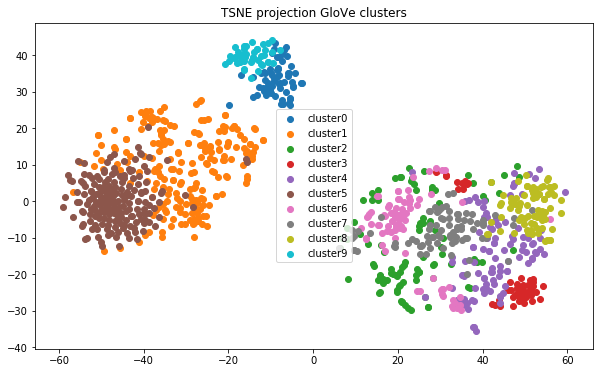

In [23]:
plt.figure(figsize=(10, 6)) 
for i in range(len(clusterCenters)):
    x = [v[0] for w,l,v in zip(words,kmeans.labels_,new_values) if l == i]
    y = [v[1] for w,l,v in zip(words,kmeans.labels_,new_values) if l == i]
    plt.scatter(x,y,label = 'cluster'+str(i))
plt.legend()
_= plt.title('TSNE projection GloVe clusters')

In [24]:
for i in range(len(clusterCenters)):
    print('Cluster: '+str(i))
    cwords = [w for w,l in zip(words,kmeans.labels_) if l == i]
    print('example words: ',cwords[:5])
    print('closest words to cluster centers: ',getMostSimilar(clusterCenters[i],glove,n=5))
    print('male ratio: ',len([w for w in cwords if w in maleBiasWords])/len(cwords))
    print("------------------")

Cluster: 0
example words:  ['refit', 'moored', 'scuttled', 'decommissioning', 'refitted']
closest words to cluster centers:  ['sunk', 'sank', 'vessel', 'ship', 'ships']
male ratio:  0.0
------------------
Cluster: 1
example words:  ['alumna', 'gabriela', 'tomboy', 'tatiana', 'handbag']
closest words to cluster centers:  ['svetlana', 'tatiana', 'daniela', 'nathalie', 'valentina']
male ratio:  0.0
------------------
Cluster: 2
example words:  ['counterintelligence', 'kitchener', 'vizier', 'draughtsman', 'caliph']
closest words to cluster centers:  ['vizier', 'abbasid', 'caliphate', 'mughal', 'pasha']
male ratio:  1.0
------------------
Cluster: 3
example words:  ['leyton', 'ballymena', 'gillingham', 'gloucestershire', 'rovers']
closest words to cluster centers:  ['barnsley', 'wolverhampton', 'colchester', 'middlesbrough', 'walsall']
male ratio:  1.0
------------------
Cluster: 4
example words:  ['bankrupt', 'winger', 'loaned', 'goalkeeper', 'boasted']
closest words to cluster centers:  [

## GNGlove

In [25]:
gnglove_file = '/scratch/um367/EMB/embeddings/wiki_gnglove.txt'
gnglove = load_emb(gnglove_file, fullLoad=False, n_vecs=50000)
len(gnglove)

50000

In [26]:
gnglove = normalizeEmb(gnglove)
gnglove = removeProtectedAttribute(gnglove)

In [27]:
vectors = [gnglove[o] for o in words]

In [28]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(vectors)
clusterCenters = kmeans.cluster_centers_
clusterCenters.shape

(10, 299)

In [29]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(vectors)

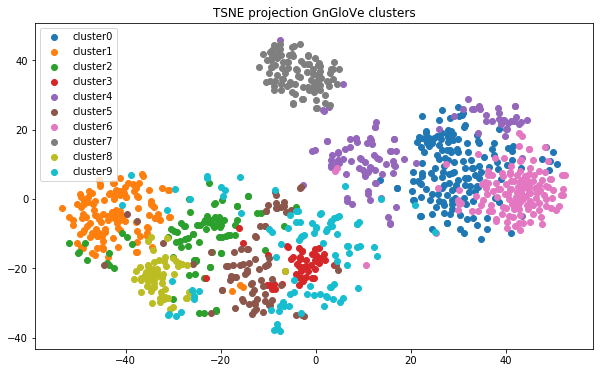

In [30]:
plt.figure(figsize=(10, 6)) 
for i in range(len(clusterCenters)):
    x = [v[0] for w,l,v in zip(words,kmeans.labels_,new_values) if l == i]
    y = [v[1] for w,l,v in zip(words,kmeans.labels_,new_values) if l == i]
    plt.scatter(x,y,label = 'cluster'+str(i))
plt.legend()
_= plt.title('TSNE projection GnGloVe clusters')

In [34]:
for i in range(len(clusterCenters)):
    print('Cluster: '+str(i))
    cwords = [w for w,l in zip(words,kmeans.labels_) if l == i]
    print(len(cwords))
    print('example words: ',cwords[:8])
    print('closest words to cluster centers: ',getMostSimilar(clusterCenters[i],gnglove,n=5))
    print('male ratio: ',len([w for w in cwords if w in maleBiasWords])/len(cwords))
    print("------------------")

Cluster: 0
157
example words:  ['gabriela', 'tatiana', 'daniela', 'gaby', 'kuznetsova', 'kristina', 'alejandra', 'sabrina']
closest words to cluster centers:  ['fiancee', 'fiancée', 'nathalie', 'monique', 'renee']
male ratio:  0.0
------------------
Cluster: 1
127
example words:  ['tackles', 'sack', 'winger', 'canadiens', 'goalkeeper', 'netting', 'catching', 'undisputed']
closest words to cluster centers:  ['rookie', 'redskins', 'nfl', 'packers', 'quarterback']
male ratio:  1.0
------------------
Cluster: 2
86
example words:  ['bankrupt', 'brescia', 'loaned', 'juventus', 'verona', 'virtus', 'pachuca', 'dinamo']
closest words to cluster centers:  ['padova', 'vicenza', 'treviso', 'brescia', 'foggia']
male ratio:  1.0
------------------
Cluster: 3
48
example words:  ['diocese', 'secular', 'ordained', 'apostolic', 'primacy', 'jesuit', 'appointment', 'granted']
closest words to cluster centers:  ['archbishop', 'vicar', 'bishops', 'bishop', 'pope']
male ratio:  1.0
------------------
Cluster